In [48]:
# import packages
import pandas as pd
pd.set_option('display.max_columns', None) # Show all columns in the DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

## Training Dataset

In [49]:
#dataset
train_data_path = 'Raw_datasets/train.csv'

read dataset in chunks

In [50]:
def read_dataset(train_data_path): 
    chunksize = 500000
    chunks = []
    for chunk in pd.read_csv(train_data_path, chunksize=chunksize, low_memory=False):
        chunks.append(chunk)
    train_data = pd.concat(chunks, ignore_index=True)
    return train_data

optimizing dataset

In [51]:
# Optimizing train_data to reduce memory usage by downcasting numerical col and converting object col to categories since all are int64, float64, object
def optimize_the_dataset(train_data):
    for col in train_data.select_dtypes(include=['int64']).columns:
        train_data[col] = pd.to_numeric(train_data[col],downcast='integer')
    for col in train_data.select_dtypes(include='float64').columns:
        train_data[col] = pd.to_numeric(train_data[col],downcast='float')
    for col in train_data.select_dtypes(include='object').columns:
        train_data[col] = train_data[col].astype('category')
    return train_data

format dataset

In [52]:
# remove trailing spaces and convert records to lowercase for consistency on categorical columns
def format_data(train_data):
    # Convert column names to lower case & remove white spaces
    train_data.columns = train_data.columns.str.lower().str.strip()
    # remove trailing white spaces and make all category to its lowercase
    train_data = train_data.apply(lambda x: x.str.lower().str.strip() if x.dtype == 'category' else x, axis=0)
    return train_data

In [53]:
data = read_dataset(train_data_path) # read dataset
optimize_train_data = optimize_the_dataset(data) # optimize ds for efficiency
train_data = format_data(optimize_train_data) # lowercase it and remove spaces

In [54]:
train_data.head()

,id,orgid,incidentid,alertid,timestamp,detectorid,alerttitle,category,mitretechniques,incidentgrade,actiongrouped,actiongranular,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,emailclusterid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,threatfamily,filename,folderpath,resourceidname,resourcetype,roles,osfamily,osversion,antispamdirection,suspicionlevel,lastverdict,countrycode,state,city
0,180388628218,0,612,123247,2024-06-04t06:05:15.000z,7,6,initialaccess,NaN,truepositive,NaN,NaN,ip,related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14t03:01:25.000z,58,43,exfiltration,NaN,falsepositive,NaN,NaN,user,impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13t04:52:55.000z,423,298,initialaccess,t1189,falsepositive,NaN,NaN,url,related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,suspicious,suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10t16:39:36.000z,2,2,commandandcontrol,NaN,benignpositive,NaN,NaN,url,related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,suspicious,suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15t01:08:07.000z,9,74,execution,NaN,truepositive,NaN,NaN,user,impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


check unique value counts

In [55]:
train_data.nunique()

id                     730778
orgid                    5769
incidentid             466151
alertid               1265644
timestamp              760944
detectorid               8428
alerttitle              86149
category                   20
mitretechniques          1193
incidentgrade               3
actiongrouped               3
actiongranular             16
entitytype                 33
evidencerole                2
deviceid                75826
sha256                 106416
ipaddress              285957
url                    123252
accountsid             358401
accountupn             530183
accountobjectid        343516
accountname            368250
devicename             114541
networkmessageid       375196
emailclusterid          26474
registrykey              1341
registryvaluename         525
registryvaluedata         699
applicationid            1728
applicationname          2681
oauthapplicationid        703
threatfamily             1680
filename               222085
folderpath

Drop Duplicates

In [56]:
print("Duplicate Entries", train_data.duplicated().sum())
train_data = train_data.drop_duplicates()
print("Duplicate Entries Dropped")

Duplicate Entries 22561
Duplicate Entries Dropped


Handling null values

In [57]:
print(train_data['incidentgrade'].isnull().sum())
# Since 'incidentgrade' is our target column, so we need to drop entire rows with null values in this column because imputing it will lead to misleading values
train_data.dropna(subset='incidentgrade', inplace=True)
print("incidentgrade Subset Dropped")

51322
incidentgrade Subset Dropped


calculate the null percentage

In [58]:
# null percentage
null_percent = (train_data.isnull().sum() / len(train_data)) * 100
print(null_percent)

id                     0.000000
orgid                  0.000000
incidentid             0.000000
alertid                0.000000
timestamp              0.000000
detectorid             0.000000
alerttitle             0.000000
category               0.000000
mitretechniques       57.381525
incidentgrade          0.000000
actiongrouped         99.949973
actiongranular        99.949973
entitytype             0.000000
evidencerole           0.000000
deviceid               0.000000
sha256                 0.000000
ipaddress              0.000000
url                    0.000000
accountsid             0.000000
accountupn             0.000000
accountobjectid        0.000000
accountname            0.000000
devicename             0.000000
networkmessageid       0.000000
emailclusterid        98.974802
registrykey            0.000000
registryvaluename      0.000000
registryvaluedata      0.000000
applicationid          0.000000
applicationname        0.000000
oauthapplicationid     0.000000
threatfa

drop columns where null > 50%

In [59]:
# drop columns where null percentage is greater than 50%
drop_null_percent_col = null_percent[null_percent > 50].index
train_data = train_data.drop(columns=drop_null_percent_col)

In [60]:
train_data.isnull().sum()

id                    0
orgid                 0
incidentid            0
alertid               0
timestamp             0
detectorid            0
alerttitle            0
category              0
incidentgrade         0
entitytype            0
evidencerole          0
deviceid              0
sha256                0
ipaddress             0
url                   0
accountsid            0
accountupn            0
accountobjectid       0
accountname           0
devicename            0
networkmessageid      0
registrykey           0
registryvaluename     0
registryvaluedata     0
applicationid         0
applicationname       0
oauthapplicationid    0
filename              0
folderpath            0
resourceidname        0
osfamily              0
osversion             0
countrycode           0
state                 0
city                  0
dtype: int64

In [61]:
train_data.head()

,id,orgid,incidentid,alertid,timestamp,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city
0,180388628218,0,612,123247,2024-06-04t06:05:15.000z,7,6,initialaccess,truepositive,ip,related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3
1,455266534868,88,326,210035,2024-06-14t03:01:25.000z,58,43,exfiltration,falsepositive,user,impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13t04:52:55.000z,423,298,initialaccess,falsepositive,url,related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10t16:39:36.000z,2,2,commandandcontrol,benignpositive,url,related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15t01:08:07.000z,9,74,execution,truepositive,user,impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [62]:
train_data.columns

Index(['id', 'orgid', 'incidentid', 'alertid', 'timestamp', 'detectorid',
       'alerttitle', 'category', 'incidentgrade', 'entitytype', 'evidencerole',
       'deviceid', 'sha256', 'ipaddress', 'url', 'accountsid', 'accountupn',
       'accountobjectid', 'accountname', 'devicename', 'networkmessageid',
       'registrykey', 'registryvaluename', 'registryvaluedata',
       'applicationid', 'applicationname', 'oauthapplicationid', 'filename',
       'folderpath', 'resourceidname', 'osfamily', 'osversion', 'countrycode',
       'state', 'city'],
      dtype='object')

remove unnecessary columns which wont contribute in model training such as id-colums

In [63]:
# ID columns that won't help in model training
id_columns = ['id', 'orgid', 'accountname','devicename','deviceid', 'sha256', 
               'ipaddress', 'url', 'accountsid', 'accountupn', 'accountobjectid',
               'networkmessageid', 'registrykey', 'registryvaluename', 
               'registryvaluedata', 'applicationid', 'applicationname', 'oauthapplicationid', 
             ]

train_data = train_data.drop(columns=id_columns)

In [64]:
train_data.shape

(9442954, 17)

Visualize Target Variable Distribution

In [65]:
# Target variable distribution
train_data['incidentgrade'].value_counts()

incidentgrade
benignpositive    4110747
truepositive      3302643
falsepositive     2029564
Name: count, dtype: int64

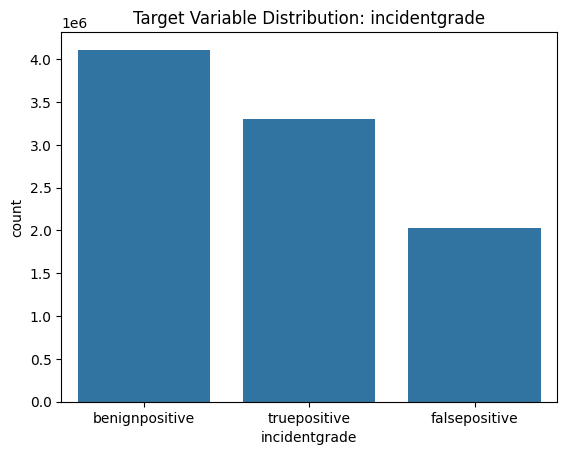

In [66]:
sns.countplot(data=train_data, x='incidentgrade', order=train_data['incidentgrade'].value_counts().index)
plt.title('Target Variable Distribution: incidentgrade')
plt.xlabel('incidentgrade')
plt.ylabel('count')
plt.show()

### Feature Engineering

In [67]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data['year'] = train_data['timestamp'].dt.year
train_data['month'] = train_data['timestamp'].dt.month
train_data['day'] = train_data['timestamp'].dt.day
train_data['hour'] = train_data['timestamp'].dt.hour

# Drop original column
train_data.drop(columns='timestamp',inplace=True)

print(train_data.columns)

Index(['incidentid', 'alertid', 'detectorid', 'alerttitle', 'category',
       'incidentgrade', 'entitytype', 'evidencerole', 'filename', 'folderpath',
       'resourceidname', 'osfamily', 'osversion', 'countrycode', 'state',
       'city', 'year', 'month', 'day', 'hour'],
      dtype='object')


In [68]:
train_data.describe()

,incidentid,alertid,detectorid,alerttitle,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour
count,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06,9.442954e+06
mean,6.956630e+04,4.029340e+05,1.066283e+02,2.778447e+03,2.620834e+05,1.075560e+05,3.583476e+03,4.898994e+00,6.466159e+01,2.236781e+02,1.351642e+03,9.937383e+03,2.024000e+03,5.909347e+00,9.797771e+00,1.215976e+01
std,1.189074e+05,4.566372e+05,4.194168e+02,1.091424e+04,8.177205e+04,3.229548e+04,9.021810e+01,7.019396e-01,9.294453e+00,6.279476e+01,3.507163e+02,2.604671e+03,4.353800e-03,2.906229e-01,6.169538e+00,6.782711e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.050000e+02,2.264800e+04,2.000000e+00,2.000000e+00,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,5.000000e+00,6.000000e+00
50%,1.022400e+04,2.135950e+05,9.000000e+00,1.100000e+01,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,9.000000e+00,1.300000e+01
75%,8.304400e+04,6.658840e+05,4.500000e+01,1.720000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,1.200000e+01,1.800000e+01
max,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,1.200000e+01,3.100000e+01,2.300000e+01


In [69]:
train_data.head()

,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour
0,612,123247,7,6,initialaccess,truepositive,ip,related,289573,117668,3586,5,66,31,6,3,2024,6,4,6
1,326,210035,58,43,exfiltration,falsepositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,14,3
2,58352,712507,423,298,initialaccess,falsepositive,url,related,289573,117668,3586,5,66,242,1445,10630,2024,6,13,4
3,32992,774301,2,2,commandandcontrol,benignpositive,url,related,289573,117668,3586,5,66,242,1445,10630,2024,6,10,16
4,4359,188041,9,74,execution,truepositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,15,1


In [70]:
train_data.shape

(9442954, 20)

In [71]:
train_data.columns

Index(['incidentid', 'alertid', 'detectorid', 'alerttitle', 'category',
       'incidentgrade', 'entitytype', 'evidencerole', 'filename', 'folderpath',
       'resourceidname', 'osfamily', 'osversion', 'countrycode', 'state',
       'city', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [72]:
train_data.nunique()

incidentid         448901
alertid           1248789
detectorid           7813
alerttitle          79952
category               20
incidentgrade           3
entitytype             33
evidencerole            2
filename           222085
folderpath          87832
resourceidname       2283
osfamily                6
osversion              58
countrycode           236
state                1368
city                 9342
year                    2
month                   8
day                    31
hour                   24
dtype: int64

In [73]:
# Export Datasets
train_data.to_csv(r"Processed_datasets/cleaned_train_data.csv", index=False)

## Testing Dataset

In [74]:
#dataset
test_data_path = 'Raw_datasets/test.csv'

In [75]:
data = read_dataset(test_data_path) # read dataset
optimize_test_data = optimize_the_dataset(data) # optimize ds for efficiency
test_data = format_data(optimize_test_data) # lowercase it and remove spaces

In [76]:
test_data.head()

,id,orgid,incidentid,alertid,timestamp,detectorid,alerttitle,category,mitretechniques,incidentgrade,actiongrouped,actiongranular,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,emailclusterid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,threatfamily,filename,folderpath,resourceidname,resourcetype,roles,osfamily,osversion,antispamdirection,suspicionlevel,lastverdict,countrycode,state,city,usage
0,1245540519230,657,11767,87199,2024-06-04t22:56:27.000z,524,563,lateralmovement,t1021;t1047;t1105;t1569.002,benignpositive,NaN,NaN,user,impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,suspicious,suspicious,242,1445,10630,private
1,1400159342154,3,91158,632273,2024-06-03t12:58:26.000z,2,2,commandandcontrol,NaN,benignpositive,NaN,NaN,machine,impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,0,0,NaN,suspicious,suspicious,242,1445,10630,public
2,1279900255923,145,32247,131719,2024-06-08t03:20:49.000z,2932,10807,lateralmovement,t1021;t1027.002;t1027.005;t1105,benignpositive,NaN,NaN,process,related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,14,22,3586,NaN,NaN,5,66,NaN,suspicious,suspicious,242,1445,10630,public
3,60129547292,222,15294,917686,2024-06-12t12:07:31.000z,0,0,initialaccess,t1078;t1078.004,falsepositive,NaN,NaN,cloudlogonsession,related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,public
4,515396080539,363,7615,5944,2024-06-06t17:42:05.000z,27,18,discovery,t1087;t1087.002,benignpositive,NaN,NaN,user,impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,suspicious,5,66,NaN,NaN,NaN,242,1445,10630,public


check unique value counts

In [77]:
train_data.nunique()

incidentid         448901
alertid           1248789
detectorid           7813
alerttitle          79952
category               20
incidentgrade           3
entitytype             33
evidencerole            2
filename           222085
folderpath          87832
resourceidname       2283
osfamily                6
osversion              58
countrycode           236
state                1368
city                 9342
year                    2
month                   8
day                    31
hour                   24
dtype: int64

Drop Duplicates

In [78]:
print("Duplicate Entries", test_data.duplicated().sum())
test_data = test_data.drop_duplicates()
print("Duplicate Entries Dropped")

Duplicate Entries 107
Duplicate Entries Dropped


Handling null values

In [79]:
print(test_data['incidentgrade'].isnull().sum())
# Since 'incidentgrade' is our target column, so we need to drop entire rows with null values in this column because imputing it will lead to misleading values
test_data.dropna(subset='incidentgrade', inplace=True)
print("incidentgrade Subset Dropped")

0
incidentgrade Subset Dropped


null percentage

In [80]:
# calculate the null percentage in all columns
null_percent = (test_data.isnull().sum() / len(test_data)) * 100
print(null_percent)

id                     0.000000
orgid                  0.000000
incidentid             0.000000
alertid                0.000000
timestamp              0.000000
detectorid             0.000000
alerttitle             0.000000
category               0.000000
mitretechniques       55.620660
incidentgrade          0.000000
actiongrouped         99.953880
actiongranular        99.953880
entitytype             0.000000
evidencerole           0.000000
deviceid               0.000000
sha256                 0.000000
ipaddress              0.000000
url                    0.000000
accountsid             0.000000
accountupn             0.000000
accountobjectid        0.000000
accountname            0.000000
devicename             0.000000
networkmessageid       0.000000
emailclusterid        98.994524
registrykey            0.000000
registryvaluename      0.000000
registryvaluedata      0.000000
applicationid          0.000000
applicationname        0.000000
oauthapplicationid     0.000000
threatfa

drop columns where null > 50%

In [81]:
# drop columns where null percentage is greater than 50%
drop_null_percent_col = null_percent[null_percent > 50].index
test_data = test_data.drop(columns=drop_null_percent_col)

In [82]:
test_data.isnull().sum()

id                    0
orgid                 0
incidentid            0
alertid               0
timestamp             0
detectorid            0
alerttitle            0
category              0
incidentgrade         0
entitytype            0
evidencerole          0
deviceid              0
sha256                0
ipaddress             0
url                   0
accountsid            0
accountupn            0
accountobjectid       0
accountname           0
devicename            0
networkmessageid      0
registrykey           0
registryvaluename     0
registryvaluedata     0
applicationid         0
applicationname       0
oauthapplicationid    0
filename              0
folderpath            0
resourceidname        0
osfamily              0
osversion             0
countrycode           0
state                 0
city                  0
usage                 0
dtype: int64

remove unnecessary columns which wont contribute in model training such as id-colums

In [83]:
# ID columns that won't help in model training
id_columns = ['id', 'orgid', 'accountname','devicename','deviceid', 'sha256', 
               'ipaddress', 'url', 'accountsid', 'accountupn', 'accountobjectid',
               'networkmessageid', 'registrykey', 'registryvaluename', 
               'registryvaluedata', 'applicationid', 'applicationname', 'oauthapplicationid', 
             ]

test_data = test_data.drop(columns=id_columns)

In [84]:
test_data.shape

(4147885, 18)

#### Visualize Target Variable Distribution

In [85]:
# Target variable distribution
test_data['incidentgrade'].value_counts()

incidentgrade
benignpositive    1752892
truepositive      1492329
falsepositive      902664
Name: count, dtype: int64

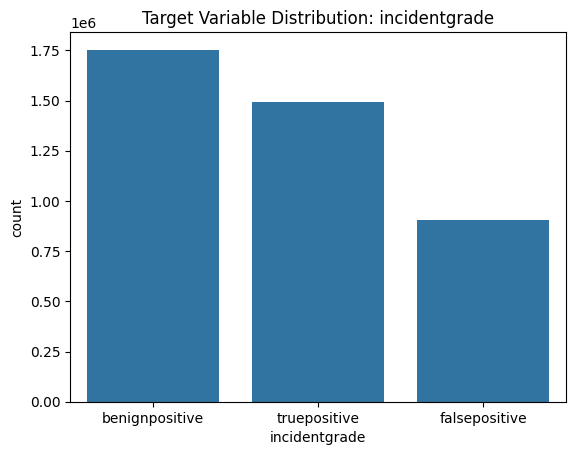

In [86]:
sns.countplot(data=test_data, x='incidentgrade', order=test_data['incidentgrade'].value_counts().index)
plt.title('Target Variable Distribution: incidentgrade')
plt.xlabel('incidentgrade')
plt.ylabel('count')
plt.show()

### Feature Engineering

In [87]:
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data['year'] = test_data['timestamp'].dt.year
test_data['month'] = test_data['timestamp'].dt.month
test_data['day'] = test_data['timestamp'].dt.day
test_data['hour'] = test_data['timestamp'].dt.hour

In [88]:
# Drop original column
test_data.drop(columns=['timestamp','usage'],inplace=True) #drop usage col because traindata doesnt have it
print(test_data.columns)

Index(['incidentid', 'alertid', 'detectorid', 'alerttitle', 'category',
       'incidentgrade', 'entitytype', 'evidencerole', 'filename', 'folderpath',
       'resourceidname', 'osfamily', 'osversion', 'countrycode', 'state',
       'city', 'year', 'month', 'day', 'hour'],
      dtype='object')


In [89]:
test_data.describe()

,incidentid,alertid,detectorid,alerttitle,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour
count,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06,4.147885e+06
mean,6.780292e+04,4.072174e+05,1.008280e+02,2.529495e+03,2.619001e+05,1.074022e+05,3.583541e+03,4.899544e+00,6.466892e+01,2.222214e+02,1.344568e+03,9.883825e+03,2.024000e+03,5.906990e+00,9.670837e+00,1.223760e+01
std,1.178734e+05,4.550590e+05,4.082710e+02,1.044148e+04,8.208397e+04,3.260323e+04,9.012240e+01,7.000809e-01,9.269034e+00,6.499881e+01,3.626882e+02,2.696326e+03,3.771461e-03,2.934652e-01,6.212269e+00,6.760920e+00
min,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.023000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.110000e+02,2.365700e+04,2.000000e+00,2.000000e+00,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,5.000000e+00,7.000000e+00
50%,8.812000e+03,2.228900e+05,7.000000e+00,9.000000e+00,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,8.000000e+00,1.300000e+01
75%,7.944200e+04,6.710990e+05,3.900000e+01,1.160000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,6.000000e+00,1.200000e+01,1.800000e+01
max,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04,2.024000e+03,1.200000e+01,3.100000e+01,2.300000e+01


In [90]:
test_data.head()

,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour
0,11767,87199,524,563,lateralmovement,benignpositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,4,22
1,91158,632273,2,2,commandandcontrol,benignpositive,machine,impacted,289573,117668,3586,0,0,242,1445,10630,2024,6,3,12
2,32247,131719,2932,10807,lateralmovement,benignpositive,process,related,14,22,3586,5,66,242,1445,10630,2024,6,8,3
3,15294,917686,0,0,initialaccess,falsepositive,cloudlogonsession,related,289573,117668,3586,5,66,242,1445,10630,2024,6,12,12
4,7615,5944,27,18,discovery,benignpositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,6,17


In [91]:
test_data.shape

(4147885, 20)

In [92]:
test_data.columns

Index(['incidentid', 'alertid', 'detectorid', 'alerttitle', 'category',
       'incidentgrade', 'entitytype', 'evidencerole', 'filename', 'folderpath',
       'resourceidname', 'osfamily', 'osversion', 'countrycode', 'state',
       'city', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [93]:
test_data.nunique()

incidentid        236267
alertid           637320
detectorid          5970
alerttitle         42265
category              19
incidentgrade          3
entitytype            29
evidencerole           2
filename          122200
folderpath         43970
resourceidname      1109
osfamily               5
osversion             43
countrycode          212
state               1159
city                6637
year                   2
month                  8
day                   31
hour                  24
dtype: int64

In [94]:
# Export Datasets
test_data.to_csv(r"Processed_datasets/cleaned_test_data.csv", index=False)
test_data.head()

,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,year,month,day,hour
0,11767,87199,524,563,lateralmovement,benignpositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,4,22
1,91158,632273,2,2,commandandcontrol,benignpositive,machine,impacted,289573,117668,3586,0,0,242,1445,10630,2024,6,3,12
2,32247,131719,2932,10807,lateralmovement,benignpositive,process,related,14,22,3586,5,66,242,1445,10630,2024,6,8,3
3,15294,917686,0,0,initialaccess,falsepositive,cloudlogonsession,related,289573,117668,3586,5,66,242,1445,10630,2024,6,12,12
4,7615,5944,27,18,discovery,benignpositive,user,impacted,289573,117668,3586,5,66,242,1445,10630,2024,6,6,17
